# Transfer Learning with TF Hub

In [2]:
import numpy as np
import time

import PIL.Image as Image
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

import datetime

2022-07-12 09:32:38.959609: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# verbosity levels
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel('ERROR')

In [4]:
# Pretrained models 
mobilenet_v2 ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4"
inception_v3 = "https://tfhub.dev/google/imagenet/inception_v3/classification/5"

classifier_model = mobilenet_v2

In [5]:
# Initial model creation
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_model, input_shape=IMAGE_SHAPE+(3,))
])

2022-07-12 09:32:48.558931: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


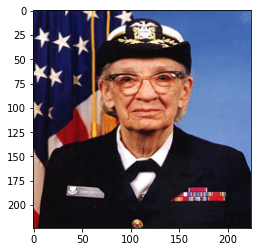

(224, 224, 3)
1/1 [==============================] - 0s 471ms/step
(1, 1001)
653


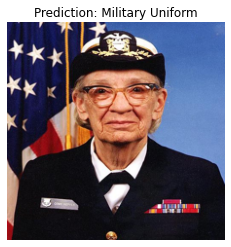

In [6]:
# Running on a single image 
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize(IMAGE_SHAPE)
plt.imshow(grace_hopper)
plt.show()
grace_hopper = np.array(grace_hopper)/255.0
print(grace_hopper.shape)
result = classifier.predict(grace_hopper[np.newaxis, ...])
print(result.shape)
print(result.argmax())

# decode predictions 
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

# Graph 
plt.imshow(grace_hopper)
plt.axis('off')
predicted_class = result.argmax()
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

# On Flower Dataset

In [7]:
# Get data
data_root = tf.keras.utils.get_file(
  'flower_photos', 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
   untar=True)

In [8]:
# split 
batch_size = 32
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
  str(data_root),
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [9]:
# View class_names
class_names = np.array(train_ds.class_names)
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


In [10]:
# Normalization layer
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y)) # Where x—images, y—labels.

In [11]:
# Performance enhancements
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# visualize 
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32,)


2022-07-12 09:32:59.627863: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [13]:
# Running classifier on batch of images (no training run)
result_batch = classifier.predict(train_ds)

92/92 [==============================] - 26s 276ms/step


In [14]:
# Switch to class_names
predicted_class_names = imagenet_labels[tf.math.argmax(result_batch, axis=-1)]
predicted_class_names

array(['daisy', 'coral fungus', 'rapeseed', ..., 'daisy', 'daisy',
       'birdhouse'], dtype='<U30')

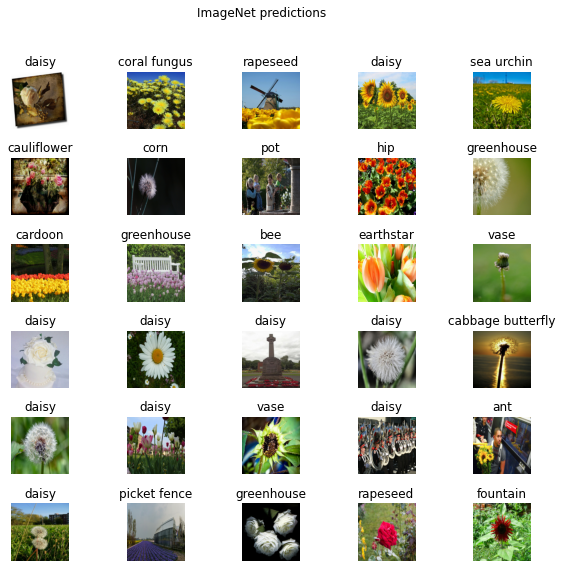

In [15]:
# visualize predictions (kind of off, not trained for daisies)
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_class_names[n])
    plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

# Headless Models

In [16]:
# Select model
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
inception_v3 = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

feature_extractor_model = mobilenet_v2

In [17]:
# Create base_model 
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

In [18]:
# Test shape
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape) # shrinks to 1280 features 

(32, 1280)


In [19]:
# Data augmentation (overfitting countermeasures)
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [22]:
# Adding classification head 
num_classes = len(class_names)

model = tf.keras.Sequential([ 
  data_augmentation, 
  feature_extractor_layer,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(num_classes)
])

output_batch = model(image_batch) 
print(output_batch)
model.summary()

tf.Tensor(
[[-0.06543058 -0.70534545 -0.10622826 -1.9286087  -0.48453242]
 [ 0.0443202  -0.33484986 -0.6120822  -0.537083    0.05960673]
 [-0.03606722 -0.08675688 -0.9725195  -1.7388763  -0.7562557 ]
 [ 0.19884026 -0.4751042  -0.47536752 -0.97354066 -0.7886504 ]
 [ 0.3447371  -1.4568455  -0.9246742  -0.92518353 -0.6538134 ]
 [-1.4026278  -1.5133418  -1.7648968  -0.6232667  -1.0008382 ]
 [-1.1927742  -0.2322995   0.5139233  -0.95454085  0.3887702 ]
 [-2.361404   -1.9718528   0.05658847 -1.3947127  -0.27167296]
 [-1.3359622  -0.06480613 -0.23253648 -1.9378684   1.0941553 ]
 [-1.4458714  -0.9843754  -0.9349697  -0.8879889   0.91198206]
 [-0.893288   -0.18439737 -0.99873227 -2.698435    1.1166939 ]
 [-1.5879247  -1.5526466  -0.20934987  0.52322674 -1.1481755 ]
 [-0.04903384 -0.773964    0.25860983 -1.2373644  -0.70392966]
 [-0.30344534 -1.7885995  -0.91517246 -1.3484827   0.578392  ]
 [-0.4971131  -0.73258424  0.85276234 -0.77488846  0.16556819]
 [-1.0612658  -1.286943   -0.5726221  -1.794

In [23]:
# Get predictions
predictions = model(image_batch)
predictions.shape # Shrinks 1280 features to 5 classes 

TensorShape([32, 5])

In [24]:
# compile
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

'''
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
#    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.
'''

# Train
NUM_EPOCHS = 10
history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=NUM_EPOCHS)
                    #callbacks=tensorboard_callback)

Epoch 1/10
92/92 [==============================] - 44s 423ms/step - loss: 0.8448 - accuracy: 0.6836 - val_loss: 0.4765 - val_accuracy: 0.8474
Epoch 2/10
92/92 [==============================] - 41s 450ms/step - loss: 0.4739 - accuracy: 0.8273 - val_loss: 0.3991 - val_accuracy: 0.8719
Epoch 3/10
92/92 [==============================] - 43s 466ms/step - loss: 0.3933 - accuracy: 0.8682 - val_loss: 0.3643 - val_accuracy: 0.8856
Epoch 4/10
92/92 [==============================] - 38s 410ms/step - loss: 0.3606 - accuracy: 0.8770 - val_loss: 0.3547 - val_accuracy: 0.8896
Epoch 5/10
92/92 [==============================] - 39s 423ms/step - loss: 0.3411 - accuracy: 0.8787 - val_loss: 0.3390 - val_accuracy: 0.8856
Epoch 6/10
92/92 [==============================] - 42s 453ms/step - loss: 0.3032 - accuracy: 0.8920 - val_loss: 0.3308 - val_accuracy: 0.8842
Epoch 7/10
92/92 [==============================] - 48s 519ms/step - loss: 0.2955 - accuracy: 0.8920 - val_loss: 0.3273 - val_accuracy: 0.8924

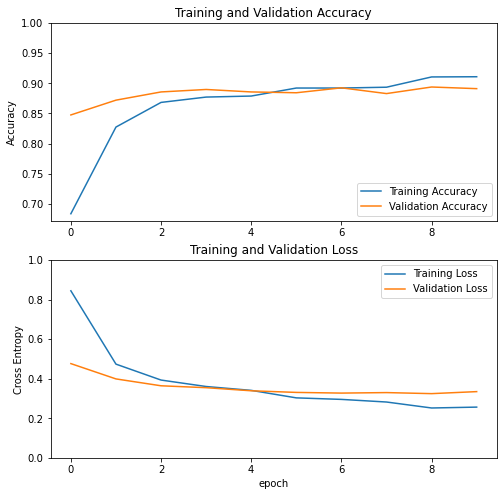

In [26]:
# Learning curves 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

1/1 [==============================] - 1s 758ms/step
['roses' 'dandelion' 'tulips' 'sunflowers' 'dandelion' 'roses' 'dandelion'
 'tulips' 'tulips' 'dandelion' 'tulips' 'tulips' 'sunflowers' 'tulips'
 'dandelion' 'roses' 'daisy' 'tulips' 'dandelion' 'dandelion' 'dandelion'
 'tulips' 'sunflowers' 'roses' 'sunflowers' 'dandelion' 'tulips' 'roses'
 'roses' 'sunflowers' 'tulips' 'sunflowers']


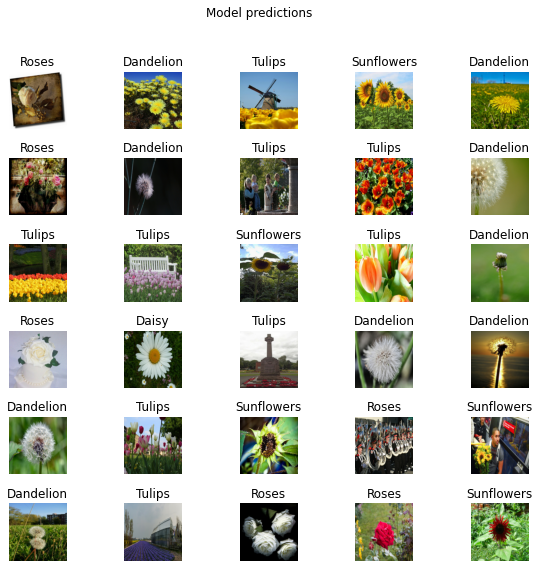

In [27]:
# Predictions
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
print(predicted_label_batch)

# visualize 
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)

for n in range(30):
    plt.subplot(6,5,n+1)
    plt.imshow(image_batch[n])
    plt.title(predicted_label_batch[n].title())
    plt.axis('off')
_ = plt.suptitle("Model predictions")

# Fine Tuning (self, no guide for this)

In [28]:
# Attempting to improve performance 
feature_extractor_layer.trainable = True

In [41]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(feature_extractor_layer))

TypeError: object of type 'KerasLayer' has no len()

In [ ]:
# Fine-tune from this layer onwards (freeze first 100 layers)
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False